In [63]:
import numpy as np 
import pandas as pd 
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from scipy import sparse
import warnings
import time
import sys
import os
import re
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',None)
pd.set_option('max_colwidth',100)
import gc 
gc.collect()

<script type="text/javascript">window.PlotlyConfig = {MathJaxConfig: 'local'};</script><script type="text/javascript">if (window.MathJax) {MathJax.Hub.Config({SVG: {font: "STIX-Web"}});}</script><script>requirejs.config({paths: { 'plotly': ['https://cdn.plot.ly/plotly-latest.min']},});if(!window._Plotly) {require(['plotly'],function(plotly) {window._Plotly=plotly;});}</script>

191

In [64]:
def modeling_cross_validation(params, X, y, nr_folds=5):
    
    oof_preds = np.zeros(X.shape[0])
    # Split data with kfold
    folds = KFold(n_splits=nr_folds, shuffle=False, random_state=4096)
    
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y)):
        print("fold n°{}".format(fold_+1))
        trn_data = lgb.Dataset(X[trn_idx], y[trn_idx])
        val_data = lgb.Dataset(X[val_idx], y[val_idx])

        num_round = 20000
        clf = lgb.train(params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 100)
        oof_preds[val_idx] = clf.predict(X[val_idx], num_iteration=clf.best_iteration)

    score = mean_squared_error(oof_preds, target)
    return  score/2
def featureSelect(init_cols):
    params = {'num_leaves': 120,
             'min_data_in_leaf': 30, 
             'objective':'regression',
             'max_depth': -1,
             'learning_rate': 0.05,
             "min_child_samples": 30,
             "boosting": "gbdt",
             "feature_fraction": 0.9,
             "bagging_freq": 1,
             "bagging_fraction": 0.9 ,
             "bagging_seed": 11,
             "metric": 'mse',
             "lambda_l1": 0.02,
             "verbosity": -1}
    best_cols = init_cols.copy()
    best_score = modeling_cross_validation(params, train[init_cols].values, target.values, nr_folds=5)
    print("初始CV score: {:<8.8f}".format(best_score))
    for f in init_cols:

        best_cols.remove(f)
        score = modeling_cross_validation(params, train[best_cols].values, target.values, nr_folds=5)
        diff = best_score - score
        print('-'*10)
        if diff > 0.00000002:
            print("当前移除特征: {}, CV score: {:<8.8f}, 最佳cv score: {:<8.8f}, 有效果,删除！！".format(f,score,best_score))
            best_score = score
        else:
            print("当前移除特征: {}, CV score: {:<8.8f}, 最佳cv score: {:<8.8f}, 没效果,保留！！".format(f,score,best_score))
            best_cols.append(f)
    print('-'*10)
    print("优化后CV score: {:<8.8f}".format(best_score))
    
    return best_cols

In [65]:
train = pd.read_csv('./jinnan_round1_train_20181227.csv', encoding = 'gb18030')
test  = pd.read_csv('./jinnan_round1_testA_20181227.csv', encoding = 'gb18030')
train.shape
#train = train[[x for x in train.index if x not in vaild.index]].copy()
# 删除类别唯一的特征
for df in [train, test]:
    df.drop(['B3', 'B13', 'A13', 'A18', 'A23'], axis=1, inplace=True)

# 删除某一类别占比超过90%的列
good_cols = list(train.columns)
for col in train.columns:
    rate = train[col].value_counts(normalize=True, dropna=False).values[0]
    if rate > 0.9:
        good_cols.remove(col)
        print(col, rate)

# 暂时不删除，后面构造特征需要
good_cols.append('A1')
good_cols.append('A3')
good_cols.append('A4')

# 删除异常值
train = train[train['收率'] > 0.87]
train = train[good_cols]
good_cols.remove('收率')
test = test[good_cols]
# 合并数据集
target = train['收率']
train['收率'] = target
data_2 = pd.concat([train,test],axis=0,ignore_index=True)
data_2 = data_2.fillna(-1)
train.shape
std = np.std(target)
mean = np.mean(target)
mean = 0.01
num = 15
column_mean_std = []
time_columns = ['A5', 'A7', 'A9', 'A11', 'A14', 'A16', 'A24', 'A26', 'B5', 'B7','A20', 'A28', 'B4', 'B9', 'B10', 'B11']
time_column = 'B10'
for time_column in time_columns:
    aa = train.groupby(by = time_column)['收率'].agg({time_column+'_count':'count',time_column+'_mean':'mean',time_column+"_std":'std'}).reset_index()
    aa = aa.fillna(100)
    aa.loc[(aa[time_column+'_std']>std) | (aa[time_column+'_count']<num),time_column+'_mean'] = mean
    aa = aa[[time_column,time_column+'_mean',time_column+"_std"]]
    column_mean_std.append(time_column+'_mean')
    column_mean_std.append(time_column+'_std')
    train = train.merge(aa,on = time_column,how = 'left')
    test = test.merge(aa,on = time_column,how = 'left')
len(column_mean_std)
data_2 = pd.concat([train[column_mean_std],test[column_mean_std]],axis=0,ignore_index=True)
data_2 = data_2.fillna(mean)

A1 0.9863896848137536
A2 0.9699140401146131
A3 0.9570200573065902
A4 0.9570200573065902
B2 0.9842406876790831


In [66]:
train = pd.read_csv('./jinnan_round1_train_20181227.csv', encoding = 'gb18030')
test  = pd.read_csv('./jinnan_round1_testA_20181227.csv', encoding = 'gb18030')
train.shape
#train = train[[x for x in train.index if x not in vaild.index]].copy()

(1396, 44)

In [67]:
#特征筛选

In [68]:
stats = []
for col in train.columns:
    stats.append((col, train[col].nunique(), train[col].isnull().sum() * 100 / train.shape[0], train[col].value_counts(normalize=True, dropna=False).values[0] * 100, train[col].dtype))
    
stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Percentage of missing values', 'Percentage of values in the biggest category', 'type'])
stats_df.sort_values('Percentage of missing values', ascending=False)[:10]

,Feature,Unique_values,Percentage of missing values,Percentage of values in the biggest category,type
2,A2,1,96.991404,96.991404,float64
7,A7,75,89.326648,89.326648,object
8,A8,8,89.326648,89.326648,float64
39,B11,37,60.816619,60.816619,object
38,B10,180,17.478510,17.478510,object
3,A3,3,3.008596,95.702006,float64
29,B1,21,0.716332,53.796562,float64
23,A23,3,0.214900,99.641834,float64
21,A21,12,0.214900,89.828080,float64
30,B2,3,0.143266,98.424069,float64


In [69]:
stats = []
for col in test.columns:
    stats.append((col, test[col].nunique(), test[col].isnull().sum() * 100 / test.shape[0], test[col].value_counts(normalize=True, dropna=False).values[0] * 100, test[col].dtype))
    
stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Percentage of missing values', 'Percentage of values in the biggest category', 'type'])
stats_df.sort_values('Percentage of missing values', ascending=False)[:10]

,Feature,Unique_values,Percentage of missing values,Percentage of values in the biggest category,type
2,A2,1,98.000000,98.000000,float64
7,A7,15,88.000000,88.000000,object
8,A8,2,88.000000,88.000000,float64
39,B11,11,59.333333,59.333333,object
38,B10,50,14.666667,14.666667,object
3,A3,2,2.000000,97.333333,float64
25,A25,7,0.666667,42.000000,float64
27,A27,11,0.666667,47.333333,float64
20,A20,52,0.666667,20.000000,object
29,B1,13,0.666667,56.000000,float64


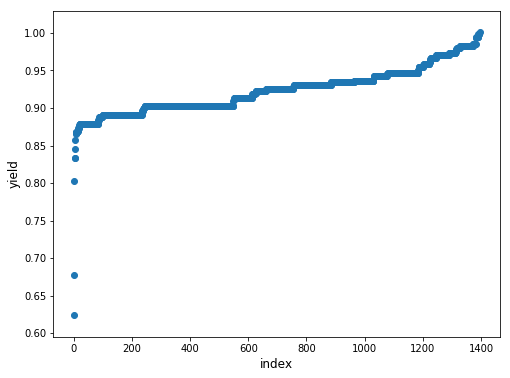

In [70]:
target_col = "收率"

plt.figure(figsize=(8,6))
plt.scatter(range(train.shape[0]), np.sort(train[target_col].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('yield', fontsize=12)
plt.show()

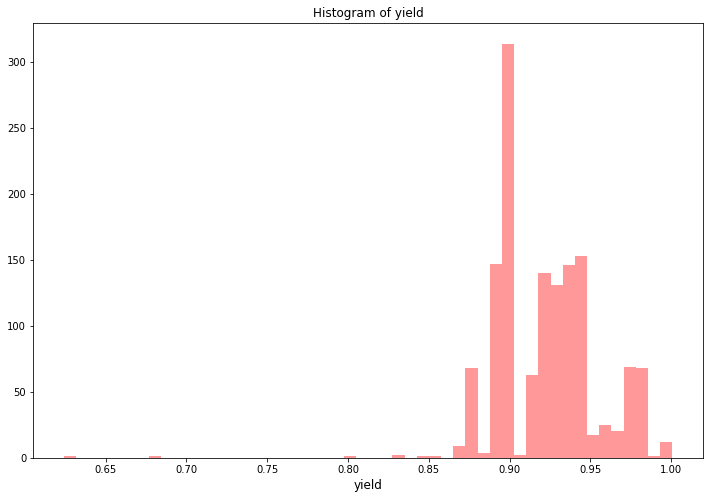

In [71]:
plt.figure(figsize=(12,8))
sns.distplot(train[target_col].values, bins=50, kde=False, color="red")
plt.title("Histogram of yield")
plt.xlabel('yield', fontsize=12)
plt.show()

In [72]:
#train['样本id'] = train['样本id'].map(lambda x:x.split('_')[1])
#plt.figure(figsize=(8,6))
#plt.scatter(train['样本id'], train[target_col])
#plt.xlabel('index', fontsize=12)
#plt.ylabel('yield', fontsize=12)
#plt.show()

In [73]:
"""
tmp = train[train[target_col]>0.92]
tmp['样本id']
plt.figure(figsize=(8,16))
plt.scatter(tmp['样本id'], tmp[target_col])
plt.xlabel('index', fontsize=12)
plt.ylabel('yield', fontsize=12)
plt.show()
train.to_csv('chakan.csv',encoding='gbk')
tmp = pd.DataFrame(np.zeros(2000))
tmp = tmp.reset_index()
tmp['index'] = tmp['index'] +1
tmp = tmp.merge(train[train[target_col]<=0.902],left_on='index' ,right_on= '样本id',how='left')
tmp.to_csv('aaa902.csv',encoding='gbk')
tmp = pd.DataFrame(np.zeros(2000))
tmp = tmp.reset_index()
tmp['index'] = tmp['index'] +1
tmp = tmp.merge(train[train[target_col]>0.902],left_on='index' ,right_on= '样本id',how='left')
tmp.to_csv('aaadayu902.csv',encoding='gbk')
num = 560
print(train.loc[865,target_col])

train['target_feature'] = mean_num
train['target_feature']
for num in range(500,600):
    pre_d_all = []
    for id in train[train[target_col]>0.92]['样本id'].values:
        sum_all = 0
        num_j = 0
        for i in [-3,-2,-1,1,2,3]:
            if (id + i * num) in train['样本id'].values:
                num_j+=1
                sum_all +=train.loc[train['样本id'] == id + i * num,target_col].values
        if num_j == 0:
            pre_d = mean_num
        else:
            pre_d = (sum_all/num_j)[0]
        pre_d_all.append([id,pre_d])
    pre_d_all = pd.DataFrame(pre_d_all)
    pre_d_all.columns =['id','pred']
    pre_d_all = pre_d_all.merge(train[['样本id',target_col]],left_on= 'id',right_on = '样本id',how='left')
    pre_d_all['mean'] = np.mean(pre_d_all[target_col])
    pre_d_all

    print('============================',num)
    print(mean_squared_error(pre_d_all[target_col],pre_d_all['pred']))
    print(mean_squared_error(pre_d_all[target_col],pre_d_all['mean']))
    pre_d_all
train[train[target_col]>0.92]['样本id']
pre_d_all = pd.DataFrame(pre_d_all)
pre_d_all[target_col] = train[target_col]
pre_d_all['mean'] = np.mean(pre_d_all[target_col])
pre_d_all
pre_d_all.columns =['id','pred' , '收率', 'mean']
print(mean_squared_error(pre_d_all[target_col],pre_d_all['pred']))
print(mean_squared_error(pre_d_all[target_col],pre_d_all['mean']))"""

"\ntmp = train[train[target_col]>0.92]\ntmp['样本id']\nplt.figure(figsize=(8,16))\nplt.scatter(tmp['样本id'], tmp[target_col])\nplt.xlabel('index', fontsize=12)\nplt.ylabel('yield', fontsize=12)\nplt.show()\ntrain.to_csv('chakan.csv',encoding='gbk')\ntmp = pd.DataFrame(np.zeros(2000))\ntmp = tmp.reset_index()\ntmp['index'] = tmp['index'] +1\ntmp = tmp.merge(train[train[target_col]<=0.902],left_on='index' ,right_on= '样本id',how='left')\ntmp.to_csv('aaa902.csv',encoding='gbk')\ntmp = pd.DataFrame(np.zeros(2000))\ntmp = tmp.reset_index()\ntmp['index'] = tmp['index'] +1\ntmp = tmp.merge(train[train[target_col]>0.902],left_on='index' ,right_on= '样本id',how='left')\ntmp.to_csv('aaadayu902.csv',encoding='gbk')\nnum = 560\nprint(train.loc[865,target_col])\n\ntrain['target_feature'] = mean_num\ntrain['target_feature']\nfor num in range(500,600):\n    pre_d_all = []\n    for id in train[train[target_col]>0.92]['样本id'].values:\n        sum_all = 0\n        num_j = 0\n        for i in [-3,-2,-1,1,2,3]:\

In [74]:
# 删除类别唯一的特征
for df in [train, test]:
    df.drop(['B3', 'B13', 'A13', 'A18', 'A23'], axis=1, inplace=True)

In [75]:
# 删除某一类别占比超过90%的列
good_cols = list(train.columns)
for col in train.columns:
    rate = train[col].value_counts(normalize=True, dropna=False).values[0]
    if rate > 0.9:
        good_cols.remove(col)
        print(col,rate)

# 暂时不删除，后面构造特征需要
good_cols.append('A1')
good_cols.append('A3')
good_cols.append('A4')

# 删除异常值
train = train[train['收率']>0.87]
        
train = train[good_cols]
good_cols.remove('收率')
test  = test[good_cols]

A1 0.9863896848137536
A2 0.9699140401146131
A3 0.9570200573065902
A4 0.9570200573065902
B2 0.9842406876790831


In [76]:
# 合并数据集
target = train['收率']
del train['收率']
data = pd.concat([train,test],axis=0,ignore_index=True)
data = data.fillna(-1)

In [77]:
def timeTranSecond(t):
    try:
        t,m,s=t.split(":")
    except:
        if t=='1900/1/9 7:00':
            return 7*3600/3600
        elif t=='1900/1/1 2:30':
            return (2*3600+30*60)/3600
        elif t==-1:
            return -1
        else:
            return 0
    
    try:
        tm = (int(t)*3600+int(m)*60+int(s))/3600
    except:
        return (30*60)/3600
    
    return tm
for f in ['A5','A7','A9','A11','A14','A16','A24','A26','B5','B7']:
    try:
        data[f] = data[f].apply(timeTranSecond)
    except:
        print(f,'应该在前面被删除了！')

def getDuration(se):
    try:
        sh,sm,eh,em=re.findall(r"\d+\.?\d*",se)
    except:
        if se == -1:
            return -1 
        
    try:
        if int(sh)>int(eh):
            tm = (int(eh)*3600+int(em)*60-int(sm)*60-int(sh)*3600)/3600 + 24
        else:
            tm = (int(eh)*3600+int(em)*60-int(sm)*60-int(sh)*3600)/3600
    except:
        if se=='19:-20:05':
            return 1
        elif se=='15:00-1600':
            return 1
    
    return tm
for f in ['A20','A28','B4','B9','B10','B11']:
    data[f+'time'] = data.apply(lambda df: getDuration(df[f]), axis=1)

In [78]:
data.columns

Index(['样本id', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A14', 'A15',
       'A16', 'A17', 'A19', 'A20', 'A21', 'A22', 'A24', 'A25', 'A26', 'A27',
       'A28', 'B1', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12',
       'B14', 'A1', 'A3', 'A4', 'A20time', 'A28time', 'B4time', 'B9time',
       'B10time', 'B11time'],
      dtype='object')

In [79]:
data['样本id'] = data['样本id'].apply(lambda x: int(x.split('_')[1]))

categorical_columns = [f for f in data.columns if f not in ['样本id']]
numerical_columns = [f for f in data.columns if f not in categorical_columns]

In [80]:
mean_num = np.mean(target)
mean_num
pred_all = []
tmp = pd.DataFrame()
tmp['样本id'] = train['样本id']
tmp['样本id'] = tmp['样本id'].map(lambda x:x.split('_')[1])
tmp['样本id'] = tmp['样本id'].astype(float)
tmp['target'] = target
tmp.reset_index(drop=True,inplace=True)
len(tmp[tmp['样本id']>2000])

0

In [81]:
#num = 20
#for i in range(1,2001):
#    tmp_data = tmp[(tmp['样本id']>= i-num) & (tmp['样本id']<= i+num) & (tmp['样本id'] != i)]
#    if len(tmp_data) != 0:
#        pred = np.mean(tmp_data['target'])
#        std = np.std(tmp_data['target'])
#        pred_all.append([i,pred,std])
#    else:
#        pred_all.append([i,mean_num,-1])

In [82]:
#data = data.merge(pred_all,on = '样本id',how = 'left')
#numerical_columns.append('pred')
#numerical_columns.append('std')
data.shape
data.columns
data.index

RangeIndex(start=0, stop=1531, step=1)

In [83]:
###温度特征data
data['wendu_mean'] = np.mean(data[['A6','A10','A12','A15','A17','A21','A25','A27','B6','B8']],axis=1)
numerical_columns.append('wendu_mean')

In [84]:
# 有风的冬老哥，在群里无意爆出来的特征，让我提升了三个个点，当然也可以顺此继续扩展
data['b14/a1_a3_a4_a19_b1_b12'] = data['B14']/(data['A1']+data['A3']+data['A4']+data['A19']+data['B1']+data['B12'])

numerical_columns.append('b14/a1_a3_a4_a19_b1_b12')

del data['A1']
del data['A3']
del data['A4']
categorical_columns.remove('A1')
categorical_columns.remove('A3')
categorical_columns.remove('A4')

In [85]:
data['A25'][data['样本id'] == 1590] = data['A25'][data['样本id'] != 1590].value_counts().values[0]
data['A25'] = data['A25'].astype(float)

In [86]:
data = pd.concat([data,data_2],axis=1)

In [87]:
data.shape

(1531, 73)

In [88]:
#label encoder
for f in categorical_columns:
    data[f] = data[f].map(dict(zip(data[f].unique(), range(0, data[f].nunique()))))
train = data[:train.shape[0]]
test  = data[train.shape[0]:]

In [89]:
numerical_columns

['样本id', 'wendu_mean', 'b14/a1_a3_a4_a19_b1_b12']

In [90]:
##mean_columns = []
##for f1 in categorical_columns:
##    cate_rate = train[f1].value_counts(normalize=True, dropna=False).values[0]
##    if cate_rate < 0.90:
##        for f2 in li:
##            col_name = 'B14_to_'+f1+"_"+f2+'_mean'
##            mean_columns.append(col_name)
##            order_label = train.groupby([f1])[f2].mean()
##            train[col_name] = train['B14'].map(order_label)
##            miss_rate = train[col_name].isnull().sum() * 100 / train[col_name].shape[0]
##            if miss_rate > 0:
##                train = train.drop([col_name], axis=1)
##                mean_columns.remove(col_name)
##            else:
##                test[col_name] = test['B14'].map(order_label)
##                
##train.drop(li+['target'], axis=1, inplace=True)
##print(train.shape)
##print(test.shape)

In [91]:
#是否进行特征筛选
train_columns_list = mean_columns+numerical_columns
best_features = featureSelect(train_columns_list)
mean_columns = [x for x in mean_columns if x in best_features]
print(len(mean_columns))
numerical_columns = [x for x in numerical_columns if x in best_features]
print(len(numerical_columns))
print(numerical_columns)

NameError: name 'mean_columns' is not defined

In [92]:
#X_train = train[mean_columns+numerical_columns].values
#X_test = test[mean_columns+numerical_columns].values
X_train = train[numerical_columns +column_mean_std].values
X_test = test[numerical_columns +column_mean_std ].values

In [93]:
train.shape

(1381, 73)

In [94]:
# one hot
enc = OneHotEncoder()
for f in categorical_columns:
    enc.fit(data[f].values.reshape(-1, 1))
    X_train = sparse.hstack((X_train, enc.transform(train[f].values.reshape(-1, 1))), 'csr')
    X_test = sparse.hstack((X_test, enc.transform(test[f].values.reshape(-1, 1))), 'csr')
print(X_test.shape)
print(X_train.shape)

(150, 2125)
(1381, 2125)


In [95]:
train.columns
print(len(mean_columns))
print(len(numerical_columns))

NameError: name 'mean_columns' is not defined

In [96]:
param = {'num_leaves': 120,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 30,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'mse',
         "lambda_l1": 0.1,
         "verbosity": -1}
folds = KFold(n_splits=5, shuffle=True, random_state=2018)
oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))
y_train = target.values
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = lgb.Dataset(X_train[trn_idx], y_train[trn_idx])
    val_data = lgb.Dataset(X_train[val_idx], y_train[val_idx])
    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=200, early_stopping_rounds = 100)
    oof_lgb[val_idx] = clf.predict(X_train[val_idx], num_iteration=clf.best_iteration)
    predictions_lgb += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_lgb, y_train)))

fold n°1
Training until validation scores don't improve for 100 rounds.


[200]	training's l2: 0.000191552	valid_1's l2: 0.000210257
[400]	training's l2: 0.000120871	valid_1's l2: 0.000147298


[600]	training's l2: 9.82821e-05	valid_1's l2: 0.000128202


[800]	training's l2: 8.79344e-05	valid_1's l2: 0.000121124
[1000]	training's l2: 8.18745e-05	valid_1's l2: 0.000117933


[1200]	training's l2: 7.72994e-05	valid_1's l2: 0.000115697
[1400]	training's l2: 7.40032e-05	valid_1's l2: 0.000114488
[1600]	training's l2: 7.13893e-05	valid_1's l2: 0.000113639
[1800]	training's l2: 6.93651e-05	valid_1's l2: 0.000113149


[2000]	training's l2: 6.79963e-05	valid_1's l2: 0.000112817
Early stopping, best iteration is:
[1940]	training's l2: 6.80694e-05	valid_1's l2: 0.000112816
fold n°2


Training until validation scores don't improve for 100 rounds.
[200]	training's l2: 0.000183875	valid_1's l2: 0.0002259
[400]	training's l2: 0.000115431	valid_1's l2: 0.000177131


[600]	training's l2: 9.28946e-05	valid_1's l2: 0.000163493


[800]	training's l2: 8.26964e-05	valid_1's l2: 0.000159939
[1000]	training's l2: 7.61322e-05	valid_1's l2: 0.000157629
[1200]	training's l2: 7.17184e-05	valid_1's l2: 0.000156338


[1400]	training's l2: 6.83386e-05	valid_1's l2: 0.000155203
[1600]	training's l2: 6.57209e-05	valid_1's l2: 0.000154346
[1800]	training's l2: 6.35091e-05	valid_1's l2: 0.000153736
[2000]	training's l2: 6.17989e-05	valid_1's l2: 0.000153544


[2200]	training's l2: 6.03342e-05	valid_1's l2: 0.000153227
Early stopping, best iteration is:
[2285]	training's l2: 5.97471e-05	valid_1's l2: 0.000152976


fold n°3
Training until validation scores don't improve for 100 rounds.
[200]	training's l2: 0.000186432	valid_1's l2: 0.000250393
[400]	training's l2: 0.000116325	valid_1's l2: 0.000186863


[600]	training's l2: 9.31547e-05	valid_1's l2: 0.000168707


[800]	training's l2: 8.28337e-05	valid_1's l2: 0.000163221
[1000]	training's l2: 7.69305e-05	valid_1's l2: 0.000161489
[1200]	training's l2: 7.29586e-05	valid_1's l2: 0.000160437


[1400]	training's l2: 6.9919e-05	valid_1's l2: 0.000159762
[1600]	training's l2: 6.75083e-05	valid_1's l2: 0.000159109
[1800]	training's l2: 6.55952e-05	valid_1's l2: 0.000158513
[2000]	training's l2: 6.40427e-05	valid_1's l2: 0.000158401
Early stopping, best iteration is:
[1937]	training's l2: 6.45011e-05	valid_1's l2: 0.000158275


fold n°4
Training until validation scores don't improve for 100 rounds.


[200]	training's l2: 0.000196918	valid_1's l2: 0.000225782
[400]	training's l2: 0.0001231	valid_1's l2: 0.000164362


[600]	training's l2: 9.8158e-05	valid_1's l2: 0.000147743
[800]	training's l2: 8.68069e-05	valid_1's l2: 0.000140983
[1000]	training's l2: 8.04172e-05	valid_1's l2: 0.000138482


[1200]	training's l2: 7.5847e-05	valid_1's l2: 0.000136976
[1400]	training's l2: 7.23205e-05	valid_1's l2: 0.000135872


[1600]	training's l2: 6.96954e-05	valid_1's l2: 0.000135238
[1800]	training's l2: 6.75247e-05	valid_1's l2: 0.000134633
[2000]	training's l2: 6.56673e-05	valid_1's l2: 0.000134364
[2200]	training's l2: 6.4657e-05	valid_1's l2: 0.000134186


Early stopping, best iteration is:
[2113]	training's l2: 6.48462e-05	valid_1's l2: 0.000134153
fold n°5
Training until validation scores don't improve for 100 rounds.


[200]	training's l2: 0.000193956	valid_1's l2: 0.000218849
[400]	training's l2: 0.000120901	valid_1's l2: 0.000148991


[600]	training's l2: 9.84676e-05	valid_1's l2: 0.000133428
[800]	training's l2: 8.7928e-05	valid_1's l2: 0.000129694
[1000]	training's l2: 8.14887e-05	valid_1's l2: 0.000128219


[1200]	training's l2: 7.67831e-05	valid_1's l2: 0.000127827
[1400]	training's l2: 7.32155e-05	valid_1's l2: 0.000127483
Early stopping, best iteration is:
[1470]	training's l2: 7.22644e-05	valid_1's l2: 0.00012739


CV score: 0.00013711


In [61]:
##### xgb
xgb_params = {'eta': 0.005, 'max_depth': 10, 'subsample': 0.8, 'colsample_bytree': 0.8, 
          'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': True, 'nthread': 4}

folds = KFold(n_splits=5, shuffle=True, random_state=2018)
oof_xgb = np.zeros(len(train))
predictions_xgb = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = xgb.DMatrix(X_train[trn_idx], y_train[trn_idx])
    val_data = xgb.DMatrix(X_train[val_idx], y_train[val_idx])

    watchlist = [(trn_data, 'train'), (val_data, 'valid_data')]
    clf = xgb.train(dtrain=trn_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=100, params=xgb_params)
    oof_xgb[val_idx] = clf.predict(xgb.DMatrix(X_train[val_idx]), ntree_limit=clf.best_ntree_limit)
    predictions_xgb += clf.predict(xgb.DMatrix(X_test), ntree_limit=clf.best_ntree_limit) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_xgb, y_train)))

fold n°1
[0]	train-rmse:0.422934	valid_data-rmse:0.423824


Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.



Will train until valid_data-rmse hasn't improved in 200 rounds.


[100]	train-rmse:0.257107	valid_data-rmse:0.258117


[200]	train-rmse:0.156776	valid_data-rmse:0.157827


[300]	train-rmse:0.096104	valid_data-rmse:0.097126


[400]	train-rmse:0.059438	valid_data-rmse:0.060414


[500]	train-rmse:0.03734	valid_data-rmse:0.03839


[600]	train-rmse:0.024069	valid_data-rmse:0.025395


[700]	train-rmse:0.016151	valid_data-rmse:0.018043


[800]	train-rmse:0.011453	valid_data-rmse:0.014167


[900]	train-rmse:0.008741	valid_data-rmse:0.012273


[1000]	train-rmse:0.007172	valid_data-rmse:0.01139


[1100]	train-rmse:0.006267	valid_data-rmse:0.01099


[1200]	train-rmse:0.005678	valid_data-rmse:0.010814


[1300]	train-rmse:0.005269	valid_data-rmse:0.010725


[1400]	train-rmse:0.004924	valid_data-rmse:0.010679


[1500]	train-rmse:0.004625	valid_data-rmse:0.010648


[1600]	train-rmse:0.004387	valid_data-rmse:0.010635


[1700]	train-rmse:0.004136	valid_data-rmse:0.010625


[1800]	train-rmse:0.003925	valid_data-rmse:0.010623


[1900]	train-rmse:0.003718	valid_data-rmse:0.01062


[2000]	train-rmse:0.003532	valid_data-rmse:0.010626


Stopping. Best iteration:
[1878]	train-rmse:0.003753	valid_data-rmse:0.010619



fold n°2
[0]	train-rmse:0.424045	valid_data-rmse:0.419348


Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.



Will train until valid_data-rmse hasn't improved in 200 rounds.


[100]	train-rmse:0.257792	valid_data-rmse:0.253856


[200]	train-rmse:0.157195	valid_data-rmse:0.153952


[300]	train-rmse:0.096332	valid_data-rmse:0.093703


[400]	train-rmse:0.059535	valid_data-rmse:0.057489


[500]	train-rmse:0.03737	valid_data-rmse:0.036144


[600]	train-rmse:0.024013	valid_data-rmse:0.023869


[700]	train-rmse:0.016048	valid_data-rmse:0.01731


[800]	train-rmse:0.011332	valid_data-rmse:0.014179


[900]	train-rmse:0.008566	valid_data-rmse:0.012847


[1000]	train-rmse:0.006995	valid_data-rmse:0.012339


[1100]	train-rmse:0.006066	valid_data-rmse:0.012174


[1200]	train-rmse:0.005522	valid_data-rmse:0.012136


[1300]	train-rmse:0.005109	valid_data-rmse:0.012149


[1400]	train-rmse:0.004782	valid_data-rmse:0.012168


Stopping. Best iteration:
[1209]	train-rmse:0.00548	valid_data-rmse:0.012135



fold n°3
[0]	train-rmse:0.422402	valid_data-rmse:0.425952


Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.



Will train until valid_data-rmse hasn't improved in 200 rounds.


[100]	train-rmse:0.256764	valid_data-rmse:0.260027


[200]	train-rmse:0.156548	valid_data-rmse:0.159473


[300]	train-rmse:0.095936	valid_data-rmse:0.098436


[400]	train-rmse:0.059361	valid_data-rmse:0.061382


[500]	train-rmse:0.037299	valid_data-rmse:0.03898


[600]	train-rmse:0.024013	valid_data-rmse:0.025765


[700]	train-rmse:0.016083	valid_data-rmse:0.018314


[800]	train-rmse:0.011386	valid_data-rmse:0.014485


[900]	train-rmse:0.008656	valid_data-rmse:0.012729


[1000]	train-rmse:0.007067	valid_data-rmse:0.011986


[1100]	train-rmse:0.006154	valid_data-rmse:0.011701


[1200]	train-rmse:0.005564	valid_data-rmse:0.011607


[1300]	train-rmse:0.005159	valid_data-rmse:0.011576


[1400]	train-rmse:0.004822	valid_data-rmse:0.011578


[1500]	train-rmse:0.004538	valid_data-rmse:0.011594


Stopping. Best iteration:
[1337]	train-rmse:0.005017	valid_data-rmse:0.011573



fold n°4
[0]	train-rmse:0.422949	valid_data-rmse:0.423757


Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.



Will train until valid_data-rmse hasn't improved in 200 rounds.


[100]	train-rmse:0.257113	valid_data-rmse:0.257003


[200]	train-rmse:0.15678	valid_data-rmse:0.155989


[300]	train-rmse:0.096111	valid_data-rmse:0.095061


[400]	train-rmse:0.059462	valid_data-rmse:0.058491


[500]	train-rmse:0.037357	valid_data-rmse:0.036719


[600]	train-rmse:0.024076	valid_data-rmse:0.024086


[700]	train-rmse:0.016129	valid_data-rmse:0.017145


[800]	train-rmse:0.011445	valid_data-rmse:0.013724


[900]	train-rmse:0.008703	valid_data-rmse:0.012206


[1000]	train-rmse:0.007147	valid_data-rmse:0.011592


[1100]	train-rmse:0.006224	valid_data-rmse:0.011378


[1200]	train-rmse:0.00567	valid_data-rmse:0.011304


[1300]	train-rmse:0.005258	valid_data-rmse:0.011277


[1400]	train-rmse:0.004945	valid_data-rmse:0.011269


[1500]	train-rmse:0.004677	valid_data-rmse:0.011266


[1600]	train-rmse:0.004453	valid_data-rmse:0.01128


Stopping. Best iteration:
[1493]	train-rmse:0.004698	valid_data-rmse:0.011264



fold n°5
[0]	train-rmse:0.42323	valid_data-rmse:0.422634


Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.



Will train until valid_data-rmse hasn't improved in 200 rounds.


[100]	train-rmse:0.257325	valid_data-rmse:0.257108


[200]	train-rmse:0.156945	valid_data-rmse:0.157062


[300]	train-rmse:0.096197	valid_data-rmse:0.096514


[400]	train-rmse:0.059544	valid_data-rmse:0.06007


[500]	train-rmse:0.037442	valid_data-rmse:0.038305


[600]	train-rmse:0.024166	valid_data-rmse:0.025499


[700]	train-rmse:0.016224	valid_data-rmse:0.018207


[800]	train-rmse:0.011541	valid_data-rmse:0.014291


[900]	train-rmse:0.008813	valid_data-rmse:0.012308


[1000]	train-rmse:0.007257	valid_data-rmse:0.01134


[1100]	train-rmse:0.006369	valid_data-rmse:0.010882


[1200]	train-rmse:0.005805	valid_data-rmse:0.010661


[1300]	train-rmse:0.005409	valid_data-rmse:0.010555


[1400]	train-rmse:0.005104	valid_data-rmse:0.010497


[1500]	train-rmse:0.004828	valid_data-rmse:0.010465


[1600]	train-rmse:0.004546	valid_data-rmse:0.010447


[1700]	train-rmse:0.004335	valid_data-rmse:0.010444


[1800]	train-rmse:0.004112	valid_data-rmse:0.010439


[1900]	train-rmse:0.003915	valid_data-rmse:0.01044


[2000]	train-rmse:0.003723	valid_data-rmse:0.010441


Stopping. Best iteration:
[1810]	train-rmse:0.004092	valid_data-rmse:0.010436



CV score: 0.00012594


In [97]:
# 将lgb和xgb的结果进行stacking
train_stack = np.vstack([oof_lgb,oof_xgb]).transpose()
test_stack = np.vstack([predictions_lgb, predictions_xgb]).transpose()
folds_stack = RepeatedKFold(n_splits=5, n_repeats=2, random_state=4590)
oof_stack = np.zeros(train_stack.shape[0])
predictions = np.zeros(test_stack.shape[0])
for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack,y_train)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], y_train[trn_idx]
    val_data, val_y = train_stack[val_idx], y_train[val_idx]
    
    clf_3 = BayesianRidge()
    clf_3.fit(trn_data, trn_y)
    
    oof_stack[val_idx] = clf_3.predict(val_data)
    predictions += clf_3.predict(test_stack) / 10
print(mean_squared_error(y_train, oof_stack))

fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
0.00012402348742621196


In [297]:
sub_df = pd.read_csv('./jinnan_round1_submit_20181227.csv', header=None)
sub_df[1] = predictions
sub_df[1] = sub_df[1].apply(lambda x:round(x, 3))

In [300]:
sub_df.to_csv('solution.csv',index=False,header=False,encoding='gbk')

In [229]:
def modeling_cross_validation(params, X, y, nr_folds=5):
    
    oof_preds = np.zeros(X.shape[0])
    # Split data with kfold
    folds = KFold(n_splits=nr_folds, shuffle=False, random_state=4096)
    
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y)):
        print("fold n°{}".format(fold_+1))
        trn_data = lgb.Dataset(X[trn_idx], y[trn_idx])
        val_data = lgb.Dataset(X[val_idx], y[val_idx])

        num_round = 20000
        clf = lgb.train(params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 100)
        oof_preds[val_idx] = clf.predict(X[val_idx], num_iteration=clf.best_iteration)

    score = mean_squared_error(oof_preds, target)
    
    return  score/2

In [235]:
def featureSelect(init_cols):
    params = {'num_leaves': 120,
             'min_data_in_leaf': 30, 
             'objective':'regression',
             'max_depth': -1,
             'learning_rate': 0.05,
             "min_child_samples": 30,
             "boosting": "gbdt",
             "feature_fraction": 0.9,
             "bagging_freq": 1,
             "bagging_fraction": 0.9 ,
             "bagging_seed": 11,
             "metric": 'mse',
             "lambda_l1": 0.02,
             "verbosity": -1}
    best_cols = init_cols.copy()
    best_score = modeling_cross_validation(params, train[init_cols].values, target.values, nr_folds=5)
    print("初始CV score: {:<8.8f}".format(best_score))
    for f in init_cols:

        best_cols.remove(f)
        score = modeling_cross_validation(params, train[best_cols].values, target.values, nr_folds=5)
        diff = best_score - score
        print('-'*10)
        if diff > 0.00000002:
            print("当前移除特征: {}, CV score: {:<8.8f}, 最佳cv score: {:<8.8f}, 有效果,删除！！".format(f,score,best_score))
            best_score = score
        else:
            print("当前移除特征: {}, CV score: {:<8.8f}, 最佳cv score: {:<8.8f}, 没效果,保留！！".format(f,score,best_score))
            best_cols.append(f)
    print('-'*10)
    print("优化后CV score: {:<8.8f}".format(best_score))
    
    return best_cols
train_columns_list = mean_columns+numerical_columns
best_features = featureSelect(train_columns_list)

fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[409]	training's l2: 6.55238e-05	valid_1's l2: 0.000140613
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[589]	training's l2: 5.81787e-05	valid_1's l2: 0.000139731
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[741]	training's l2: 5.87955e-05	valid_1's l2: 0.000110804
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[255]	training's l2: 7.94528e-05	valid_1's l2: 0.000110474
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[127]	training's l2: 9.48896e-05	valid_1's l2: 0.000147151
初始CV score: 0.00006488
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[313]	training's l2: 7.1517e-05	valid_1's l2: 0.000138039
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[589]	training's l2: 5.83178e-05	valid_1's l2: 0.000137984
fold n°3
Training until validation scores don't improve for 100 rounds.


[1000]	training's l2: 5.37443e-05	valid_1's l2: 0.000112393
Early stopping, best iteration is:
[911]	training's l2: 5.53951e-05	valid_1's l2: 0.000111515
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[274]	training's l2: 7.72914e-05	valid_1's l2: 0.00010869
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[238]	training's l2: 7.74774e-05	valid_1's l2: 0.000144568
----------
当前移除特征: B14_to_A5_intTarget_0_mean, CV score: 0.00006408, 最佳cv score: 0.00006488, 有效果,删除！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[456]	training's l2: 6.34015e-05	valid_1's l2: 0.000138542
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[511]	training's l2: 6.12451e-05	valid_1's l2: 0.000138774
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[739]	training's l2: 5.92715e-05	valid_1's l2: 0.000111486
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[271]	training's l2: 7.84673e-05	valid_1's l2: 0.000109117
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[227]	training's l2: 7.90269e-05	valid_1's l2: 0.000145034
----------
当前移除特征: B14_to_A5_intTarget_1_mean, CV score: 0.00006430, 最佳cv score: 0.00006408, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[299]	training's l2: 7.239e-05	valid_1's l2: 0.000141338
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[589]	training's l2: 5.81139e-05	valid_1's l2: 0.000137618
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[677]	training's l2: 6.0634e-05	valid_1's l2: 0.000111074
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[228]	training's l2: 8.24597e-05	valid_1's l2: 0.000110153
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[177]	training's l2: 8.46574e-05	valid_1's l2: 0.000146266
----------
当前移除特征: B14_to_A5_intTarget_2_mean, CV score: 0.00006465, 最佳cv score: 0.00006408, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[288]	training's l2: 7.33103e-05	valid_1's l2: 0.000139385
fold n°2


Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[494]	training's l2: 6.17622e-05	valid_1's l2: 0.000137366
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[736]	training's l2: 5.92413e-05	valid_1's l2: 0.000110242
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[282]	training's l2: 7.71466e-05	valid_1's l2: 0.000109644


fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[129]	training's l2: 9.46227e-05	valid_1's l2: 0.000142786
----------
当前移除特征: B14_to_A5_intTarget_3_mean, CV score: 0.00006395, 最佳cv score: 0.00006408, 有效果,删除！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[350]	training's l2: 6.92445e-05	valid_1's l2: 0.000141494
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[379]	training's l2: 6.75586e-05	valid_1's l2: 0.000137583
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[741]	training's l2: 5.91243e-05	valid_1's l2: 0.000110622
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[251]	training's l2: 8.0187e-05	valid_1's l2: 0.000110237
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[180]	training's l2: 8.52169e-05	valid_1's l2: 0.000147028
----------
当前移除特征: B14_to_A5_intTarget_4_mean, CV score: 0.00006470, 最佳cv score: 0.00006395, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[335]	training's l2: 7.01543e-05	valid_1's l2: 0.000139509
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[336]	training's l2: 7.05112e-05	valid_1's l2: 0.000139831
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[741]	training's l2: 5.89467e-05	valid_1's l2: 0.000110952
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[280]	training's l2: 7.71863e-05	valid_1's l2: 0.000111259
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[198]	training's l2: 8.24112e-05	valid_1's l2: 0.000145361


----------
当前移除特征: B14_to_A6_intTarget_0_mean, CV score: 0.00006469, 最佳cv score: 0.00006395, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[340]	training's l2: 6.93758e-05	valid_1's l2: 0.00014011
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[515]	training's l2: 6.11294e-05	valid_1's l2: 0.000138998
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[746]	training's l2: 5.8702e-05	valid_1's l2: 0.00010891
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[251]	training's l2: 8.00603e-05	valid_1's l2: 0.000109152
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[197]	training's l2: 8.23731e-05	valid_1's l2: 0.00014639
----------
当前移除特征: B14_to_A6_intTarget_1_mean, CV score: 0.00006436, 最佳cv score: 0.00006395, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[293]	training's l2: 7.33361e-05	valid_1's l2: 0.000139945
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[590]	training's l2: 5.83905e-05	valid_1's l2: 0.000140415
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[743]	training's l2: 5.89751e-05	valid_1's l2: 0.000111304
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[330]	training's l2: 7.31355e-05	valid_1's l2: 0.000109867
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[171]	training's l2: 8.56552e-05	valid_1's l2: 0.0001438
----------
当前移除特征: B14_to_A6_intTarget_2_mean, CV score: 0.00006454, 最佳cv score: 0.00006395, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[299]	training's l2: 7.28246e-05	valid_1's l2: 0.000138797
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[639]	training's l2: 5.68279e-05	valid_1's l2: 0.000138937
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[746]	training's l2: 5.88736e-05	valid_1's l2: 0.000109693
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[290]	training's l2: 7.59508e-05	valid_1's l2: 0.000108728


fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[127]	training's l2: 9.48407e-05	valid_1's l2: 0.000144003
----------
当前移除特征: B14_to_A6_intTarget_3_mean, CV score: 0.00006402, 最佳cv score: 0.00006395, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[314]	training's l2: 7.1139e-05	valid_1's l2: 0.000140009
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[643]	training's l2: 5.67912e-05	valid_1's l2: 0.000137272
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[741]	training's l2: 5.89881e-05	valid_1's l2: 0.000110513
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[225]	training's l2: 8.26337e-05	valid_1's l2: 0.00010913
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[180]	training's l2: 8.42846e-05	valid_1's l2: 0.000144446
----------
当前移除特征: B14_to_A6_intTarget_4_mean, CV score: 0.00006414, 最佳cv score: 0.00006395, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[314]	training's l2: 7.13715e-05	valid_1's l2: 0.000141387
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[563]	training's l2: 5.94495e-05	valid_1's l2: 0.000138974
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[678]	training's l2: 6.05242e-05	valid_1's l2: 0.000110787
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[327]	training's l2: 7.34784e-05	valid_1's l2: 0.000108484
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[236]	training's l2: 7.73225e-05	valid_1's l2: 0.000145468
----------
当前移除特征: B14_to_A7_intTarget_0_mean, CV score: 0.00006451, 最佳cv score: 0.00006395, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[297]	training's l2: 7.27229e-05	valid_1's l2: 0.000143751
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[590]	training's l2: 5.84781e-05	valid_1's l2: 0.000137687
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[747]	training's l2: 5.90484e-05	valid_1's l2: 0.000111083
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[256]	training's l2: 7.93914e-05	valid_1's l2: 0.000109003
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[127]	training's l2: 9.4246e-05	valid_1's l2: 0.000145327
----------
当前移除特征: B14_to_A7_intTarget_1_mean, CV score: 0.00006469, 最佳cv score: 0.00006395, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[313]	training's l2: 7.20998e-05	valid_1's l2: 0.00014351
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[589]	training's l2: 5.89052e-05	valid_1's l2: 0.000138724
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[748]	training's l2: 5.88644e-05	valid_1's l2: 0.000110997
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[292]	training's l2: 7.65859e-05	valid_1's l2: 0.000109978
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[127]	training's l2: 9.41339e-05	valid_1's l2: 0.000145548
----------
当前移除特征: B14_to_A7_intTarget_2_mean, CV score: 0.00006488, 最佳cv score: 0.00006395, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[408]	training's l2: 6.67331e-05	valid_1's l2: 0.000143992
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[589]	training's l2: 5.89427e-05	valid_1's l2: 0.000139574
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[866]	training's l2: 5.67046e-05	valid_1's l2: 0.000111328
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[256]	training's l2: 8.02394e-05	valid_1's l2: 0.000110653
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[127]	training's l2: 9.49791e-05	valid_1's l2: 0.000146261
----------


当前移除特征: B14_to_A7_intTarget_3_mean, CV score: 0.00006519, 最佳cv score: 0.00006395, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[313]	training's l2: 7.16965e-05	valid_1's l2: 0.00014357
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[643]	training's l2: 5.69706e-05	valid_1's l2: 0.000137918
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[704]	training's l2: 6.00016e-05	valid_1's l2: 0.000111502
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[258]	training's l2: 7.89576e-05	valid_1's l2: 0.000108865
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[127]	training's l2: 9.50915e-05	valid_1's l2: 0.000144415
----------
当前移除特征: B14_to_A7_intTarget_4_mean, CV score: 0.00006463, 最佳cv score: 0.00006395, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[408]	training's l2: 6.58352e-05	valid_1's l2: 0.000142815
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[589]	training's l2: 5.85502e-05	valid_1's l2: 0.000137823
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[739]	training's l2: 5.90056e-05	valid_1's l2: 0.000110875
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[327]	training's l2: 7.35586e-05	valid_1's l2: 0.000109337
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[198]	training's l2: 8.18322e-05	valid_1's l2: 0.000146207
----------
当前移除特征: B14_to_A9_intTarget_0_mean, CV score: 0.00006471, 最佳cv score: 0.00006395, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[300]	training's l2: 7.25901e-05	valid_1's l2: 0.000144346
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[619]	training's l2: 5.73725e-05	valid_1's l2: 0.000138734
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[741]	training's l2: 5.89332e-05	valid_1's l2: 0.000111876
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[256]	training's l2: 7.93137e-05	valid_1's l2: 0.000109706
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[235]	training's l2: 7.76178e-05	valid_1's l2: 0.000146425
----------
当前移除特征: B14_to_A9_intTarget_1_mean, CV score: 0.00006511, 最佳cv score: 0.00006395, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[286]	training's l2: 7.36392e-05	valid_1's l2: 0.000141556
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[604]	training's l2: 5.7966e-05	valid_1's l2: 0.000137621
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[713]	training's l2: 5.97522e-05	valid_1's l2: 0.000111407
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[226]	training's l2: 8.29709e-05	valid_1's l2: 0.000109976
fold n°5


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[127]	training's l2: 9.46553e-05	valid_1's l2: 0.000143398
----------
当前移除特征: B14_to_A9_intTarget_2_mean, CV score: 0.00006440, 最佳cv score: 0.00006395, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[408]	training's l2: 6.66114e-05	valid_1's l2: 0.000142373
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[590]	training's l2: 5.89679e-05	valid_1's l2: 0.000138812
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[711]	training's l2: 6.01803e-05	valid_1's l2: 0.000111635
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[255]	training's l2: 8.02336e-05	valid_1's l2: 0.000109815


fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[128]	training's l2: 9.50012e-05	valid_1's l2: 0.000145803
----------
当前移除特征: B14_to_A9_intTarget_3_mean, CV score: 0.00006485, 最佳cv score: 0.00006395, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[337]	training's l2: 6.9809e-05	valid_1's l2: 0.000141467
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[417]	training's l2: 6.5018e-05	valid_1's l2: 0.000137722
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[745]	training's l2: 5.89807e-05	valid_1's l2: 0.000110715
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[216]	training's l2: 8.35e-05	valid_1's l2: 0.000107394


fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[198]	training's l2: 8.22039e-05	valid_1's l2: 0.000144017
----------
当前移除特征: B14_to_A9_intTarget_4_mean, CV score: 0.00006414, 最佳cv score: 0.00006395, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[314]	training's l2: 7.12942e-05	valid_1's l2: 0.000141688
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[497]	training's l2: 6.19913e-05	valid_1's l2: 0.000137223
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[745]	training's l2: 5.90077e-05	valid_1's l2: 0.000111447
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[328]	training's l2: 7.30907e-05	valid_1's l2: 0.000110487
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[171]	training's l2: 8.57747e-05	valid_1's l2: 0.000145573
----------
当前移除特征: B14_to_A11_intTarget_0_mean, CV score: 0.00006465, 最佳cv score: 0.00006395, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[317]	training's l2: 7.13282e-05	valid_1's l2: 0.000143321
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[498]	training's l2: 6.15656e-05	valid_1's l2: 0.000138657
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[866]	training's l2: 5.60788e-05	valid_1's l2: 0.000110693
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[260]	training's l2: 7.9038e-05	valid_1's l2: 0.000110486
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[191]	training's l2: 8.32281e-05	valid_1's l2: 0.000145639
----------
当前移除特征: B14_to_A11_intTarget_1_mean, CV score: 0.00006488, 最佳cv score: 0.00006395, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[308]	training's l2: 7.27933e-05	valid_1's l2: 0.000143055
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[589]	training's l2: 5.87359e-05	valid_1's l2: 0.000139519
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[741]	training's l2: 5.90583e-05	valid_1's l2: 0.000111621
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[282]	training's l2: 7.71809e-05	valid_1's l2: 0.000110052
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[240]	training's l2: 7.79466e-05	valid_1's l2: 0.000145249
----------
当前移除特征: B14_to_A11_intTarget_2_mean, CV score: 0.00006495, 最佳cv score: 0.00006395, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[335]	training's l2: 7.04148e-05	valid_1's l2: 0.000143644
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[496]	training's l2: 6.15558e-05	valid_1's l2: 0.000137569
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[739]	training's l2: 5.90749e-05	valid_1's l2: 0.000111713
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[258]	training's l2: 7.9168e-05	valid_1's l2: 0.000109366
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[180]	training's l2: 8.4514e-05	valid_1's l2: 0.000144031
----------
当前移除特征: B14_to_A11_intTarget_3_mean, CV score: 0.00006464, 最佳cv score: 0.00006395, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[288]	training's l2: 7.38119e-05	valid_1's l2: 0.000141444
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[589]	training's l2: 5.8385e-05	valid_1's l2: 0.000137509
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[739]	training's l2: 5.91548e-05	valid_1's l2: 0.000110226
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[320]	training's l2: 7.38774e-05	valid_1's l2: 0.000108331
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[126]	training's l2: 9.44508e-05	valid_1's l2: 0.000142474
----------
当前移除特征: B14_to_A11_intTarget_4_mean, CV score: 0.00006400, 最佳cv score: 0.00006395, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[300]	training's l2: 7.31286e-05	valid_1's l2: 0.000143334
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[563]	training's l2: 5.95081e-05	valid_1's l2: 0.000137228
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[731]	training's l2: 5.96452e-05	valid_1's l2: 0.00011087
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[258]	training's l2: 7.93629e-05	valid_1's l2: 0.000109703
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[197]	training's l2: 8.25588e-05	valid_1's l2: 0.000146259
----------
当前移除特征: B14_to_A14_intTarget_0_mean, CV score: 0.00006474, 最佳cv score: 0.00006395, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[292]	training's l2: 7.31662e-05	valid_1's l2: 0.000142138
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[563]	training's l2: 5.94366e-05	valid_1's l2: 0.000137959
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[746]	training's l2: 5.92535e-05	valid_1's l2: 0.000111096
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[258]	training's l2: 7.88336e-05	valid_1's l2: 0.000109476
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[198]	training's l2: 8.26504e-05	valid_1's l2: 0.000146316
----------
当前移除特征: B14_to_A14_intTarget_1_mean, CV score: 0.00006470, 最佳cv score: 0.00006395, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[361]	training's l2: 6.85038e-05	valid_1's l2: 0.000141198
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[589]	training's l2: 5.87218e-05	valid_1's l2: 0.000135825
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[713]	training's l2: 6.01849e-05	valid_1's l2: 0.000111142
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[330]	training's l2: 7.33237e-05	valid_1's l2: 0.00010924
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[177]	training's l2: 8.4403e-05	valid_1's l2: 0.000143068
----------
当前移除特征: B14_to_A14_intTarget_2_mean, CV score: 0.00006405, 最佳cv score: 0.00006395, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[339]	training's l2: 7.04362e-05	valid_1's l2: 0.000142825
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[497]	training's l2: 6.20313e-05	valid_1's l2: 0.000138001
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[870]	training's l2: 5.6369e-05	valid_1's l2: 0.000109844
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[327]	training's l2: 7.38291e-05	valid_1's l2: 0.000111094
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[127]	training's l2: 9.46164e-05	valid_1's l2: 0.000144751
----------
当前移除特征: B14_to_A14_intTarget_3_mean, CV score: 0.00006466, 最佳cv score: 0.00006395, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[320]	training's l2: 7.11786e-05	valid_1's l2: 0.000144075
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[535]	training's l2: 6.03858e-05	valid_1's l2: 0.000137063
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[741]	training's l2: 5.92248e-05	valid_1's l2: 0.000110202
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[327]	training's l2: 7.31981e-05	valid_1's l2: 0.000109531
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[173]	training's l2: 8.65602e-05	valid_1's l2: 0.000144892
----------
当前移除特征: B14_to_A14_intTarget_4_mean, CV score: 0.00006458, 最佳cv score: 0.00006395, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[314]	training's l2: 7.13032e-05	valid_1's l2: 0.00014244
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[595]	training's l2: 5.82736e-05	valid_1's l2: 0.000138957
fold n°3
Training until validation scores don't improve for 100 rounds.


[1000]	training's l2: 5.4041e-05	valid_1's l2: 0.000112055
Early stopping, best iteration is:
[909]	training's l2: 5.56426e-05	valid_1's l2: 0.000111117
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[230]	training's l2: 8.20536e-05	valid_1's l2: 0.000109864


fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[154]	training's l2: 8.91136e-05	valid_1's l2: 0.000144583
----------
当前移除特征: B14_to_A16_intTarget_0_mean, CV score: 0.00006470, 最佳cv score: 0.00006395, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[407]	training's l2: 6.53416e-05	valid_1's l2: 0.000142351
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[589]	training's l2: 5.78822e-05	valid_1's l2: 0.000137604
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[734]	training's l2: 5.8891e-05	valid_1's l2: 0.000110145
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[256]	training's l2: 7.85336e-05	valid_1's l2: 0.000108434
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[127]	training's l2: 9.33896e-05	valid_1's l2: 0.000144442
----------
当前移除特征: B14_to_A16_intTarget_1_mean, CV score: 0.00006430, 最佳cv score: 0.00006395, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[409]	training's l2: 6.61375e-05	valid_1's l2: 0.000140476
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[589]	training's l2: 5.86726e-05	valid_1's l2: 0.000138594
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[746]	training's l2: 5.88759e-05	valid_1's l2: 0.000110306
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[282]	training's l2: 7.7035e-05	valid_1's l2: 0.000109535
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[122]	training's l2: 9.69297e-05	valid_1's l2: 0.000144163
----------
当前移除特征: B14_to_A16_intTarget_2_mean, CV score: 0.00006431, 最佳cv score: 0.00006395, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[288]	training's l2: 7.3876e-05	valid_1's l2: 0.000144251
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[599]	training's l2: 5.84505e-05	valid_1's l2: 0.000137646
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[868]	training's l2: 5.62363e-05	valid_1's l2: 0.000111569
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[327]	training's l2: 7.36114e-05	valid_1's l2: 0.00010977
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[166]	training's l2: 8.73827e-05	valid_1's l2: 0.000144898
----------
当前移除特征: B14_to_A16_intTarget_3_mean, CV score: 0.00006482, 最佳cv score: 0.00006395, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[239]	training's l2: 7.79653e-05	valid_1's l2: 0.000141169
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[589]	training's l2: 5.86073e-05	valid_1's l2: 0.000139589
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[741]	training's l2: 5.9057e-05	valid_1's l2: 0.000111278
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[329]	training's l2: 7.3283e-05	valid_1's l2: 0.000109179
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[127]	training's l2: 9.47608e-05	valid_1's l2: 0.000144565
----------
当前移除特征: B14_to_A16_intTarget_4_mean, CV score: 0.00006458, 最佳cv score: 0.00006395, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[340]	training's l2: 7.00675e-05	valid_1's l2: 0.000142476
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[562]	training's l2: 5.97675e-05	valid_1's l2: 0.000136982
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[711]	training's l2: 6.00565e-05	valid_1's l2: 0.000110917
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[260]	training's l2: 7.94251e-05	valid_1's l2: 0.000109029
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[184]	training's l2: 8.42299e-05	valid_1's l2: 0.000147032
----------
当前移除特征: B14_to_A24_intTarget_0_mean, CV score: 0.00006465, 最佳cv score: 0.00006395, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[288]	training's l2: 7.3714e-05	valid_1's l2: 0.000142152
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[563]	training's l2: 5.96433e-05	valid_1's l2: 0.000138151
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[741]	training's l2: 5.8887e-05	valid_1's l2: 0.00011124
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[308]	training's l2: 7.50896e-05	valid_1's l2: 0.000107654
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[240]	training's l2: 7.71268e-05	valid_1's l2: 0.000143238
----------
当前移除特征: B14_to_A24_intTarget_1_mean, CV score: 0.00006425, 最佳cv score: 0.00006395, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[299]	training's l2: 7.3206e-05	valid_1's l2: 0.000143816
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[589]	training's l2: 5.84103e-05	valid_1's l2: 0.000137879
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[700]	training's l2: 6.01297e-05	valid_1's l2: 0.000111878
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[258]	training's l2: 7.96331e-05	valid_1's l2: 0.000110309
fold n°5


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[127]	training's l2: 9.58513e-05	valid_1's l2: 0.000145878
----------
当前移除特征: B14_to_A24_intTarget_2_mean, CV score: 0.00006498, 最佳cv score: 0.00006395, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[299]	training's l2: 7.26834e-05	valid_1's l2: 0.000142529
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[594]	training's l2: 5.84821e-05	valid_1's l2: 0.000139439
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[742]	training's l2: 5.90557e-05	valid_1's l2: 0.000112453
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[327]	training's l2: 7.35043e-05	valid_1's l2: 0.000110542
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[127]	training's l2: 9.48198e-05	valid_1's l2: 0.00014541
----------
当前移除特征: B14_to_A24_intTarget_3_mean, CV score: 0.00006504, 最佳cv score: 0.00006395, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[314]	training's l2: 7.1088e-05	valid_1's l2: 0.000142946
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[589]	training's l2: 5.8393e-05	valid_1's l2: 0.000137768
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[719]	training's l2: 5.93952e-05	valid_1's l2: 0.000112451
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[327]	training's l2: 7.31619e-05	valid_1's l2: 0.0001098
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[183]	training's l2: 8.33041e-05	valid_1's l2: 0.000144244
----------
当前移除特征: B14_to_A24_intTarget_4_mean, CV score: 0.00006473, 最佳cv score: 0.00006395, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[314]	training's l2: 7.13717e-05	valid_1's l2: 0.000142811
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[589]	training's l2: 5.84044e-05	valid_1's l2: 0.000139488
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[741]	training's l2: 5.91178e-05	valid_1's l2: 0.000111782
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[331]	training's l2: 7.28677e-05	valid_1's l2: 0.000110921
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[198]	training's l2: 8.13637e-05	valid_1's l2: 0.000146272
----------


当前移除特征: B14_to_A26_intTarget_0_mean, CV score: 0.00006513, 最佳cv score: 0.00006395, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[396]	training's l2: 6.62878e-05	valid_1's l2: 0.000143482
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[497]	training's l2: 6.16446e-05	valid_1's l2: 0.000136969
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[677]	training's l2: 6.077e-05	valid_1's l2: 0.000110667
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[327]	training's l2: 7.32271e-05	valid_1's l2: 0.000109971
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[127]	training's l2: 9.3812e-05	valid_1's l2: 0.000144454
----------
当前移除特征: B14_to_A26_intTarget_1_mean, CV score: 0.00006456, 最佳cv score: 0.00006395, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[454]	training's l2: 6.38368e-05	valid_1's l2: 0.000143557
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[589]	training's l2: 5.87323e-05	valid_1's l2: 0.000137353
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[718]	training's l2: 5.95165e-05	valid_1's l2: 0.00011256
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[237]	training's l2: 8.13655e-05	valid_1's l2: 0.000109519


fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[163]	training's l2: 8.72904e-05	valid_1's l2: 0.000146502
----------
当前移除特征: B14_to_A26_intTarget_2_mean, CV score: 0.00006495, 最佳cv score: 0.00006395, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[292]	training's l2: 7.34395e-05	valid_1's l2: 0.000140969
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[498]	training's l2: 6.14762e-05	valid_1's l2: 0.000139837
fold n°3
Training until validation scores don't improve for 100 rounds.


[1000]	training's l2: 5.36843e-05	valid_1's l2: 0.000112996
Early stopping, best iteration is:
[910]	training's l2: 5.52484e-05	valid_1's l2: 0.000112121
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[228]	training's l2: 8.25474e-05	valid_1's l2: 0.000109707
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[248]	training's l2: 7.6146e-05	valid_1's l2: 0.000144601
----------
当前移除特征: B14_to_A26_intTarget_3_mean, CV score: 0.00006473, 最佳cv score: 0.00006395, 没效果,保留！！
fold n°1


Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[362]	training's l2: 6.85421e-05	valid_1's l2: 0.000144398
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[556]	training's l2: 5.95741e-05	valid_1's l2: 0.000139498
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[741]	training's l2: 5.89822e-05	valid_1's l2: 0.00011102
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[274]	training's l2: 7.7581e-05	valid_1's l2: 0.000109711
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[278]	training's l2: 7.39054e-05	valid_1's l2: 0.000145037
----------


当前移除特征: B14_to_A26_intTarget_4_mean, CV score: 0.00006497, 最佳cv score: 0.00006395, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[244]	training's l2: 7.74974e-05	valid_1's l2: 0.000144025
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[596]	training's l2: 5.83922e-05	valid_1's l2: 0.000138786
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[734]	training's l2: 5.92369e-05	valid_1's l2: 0.000111011
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[273]	training's l2: 7.75983e-05	valid_1's l2: 0.000111086
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[127]	training's l2: 9.51302e-05	valid_1's l2: 0.000145867
----------
当前移除特征: B14_to_B1_intTarget_0_mean, CV score: 0.00006508, 最佳cv score: 0.00006395, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[324]	training's l2: 7.14917e-05	valid_1's l2: 0.000141921
fold n°2


Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[529]	training's l2: 6.08891e-05	valid_1's l2: 0.000137304
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[740]	training's l2: 5.89752e-05	valid_1's l2: 0.000110216
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[285]	training's l2: 7.71617e-05	valid_1's l2: 0.000108633
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[197]	training's l2: 8.23886e-05	valid_1's l2: 0.000146181


----------
当前移除特征: B14_to_B1_intTarget_1_mean, CV score: 0.00006443, 最佳cv score: 0.00006395, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[383]	training's l2: 6.76582e-05	valid_1's l2: 0.000141329
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[556]	training's l2: 5.98686e-05	valid_1's l2: 0.000137132
fold n°3
Training until validation scores don't improve for 100 rounds.


[1000]	training's l2: 5.40831e-05	valid_1's l2: 0.000111902
Early stopping, best iteration is:
[909]	training's l2: 5.5672e-05	valid_1's l2: 0.000110851
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[328]	training's l2: 7.39876e-05	valid_1's l2: 0.00010952
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[160]	training's l2: 8.78812e-05	valid_1's l2: 0.00014545
----------
当前移除特征: B14_to_B1_intTarget_2_mean, CV score: 0.00006443, 最佳cv score: 0.00006395, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[353]	training's l2: 6.8979e-05	valid_1's l2: 0.000140614
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[494]	training's l2: 6.20833e-05	valid_1's l2: 0.000139237
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[743]	training's l2: 5.89269e-05	valid_1's l2: 0.000109965
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[210]	training's l2: 8.48254e-05	valid_1's l2: 0.000110365


fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[192]	training's l2: 8.26931e-05	valid_1's l2: 0.000144529
----------
当前移除特征: B14_to_B1_intTarget_3_mean, CV score: 0.00006448, 最佳cv score: 0.00006395, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[292]	training's l2: 7.35043e-05	valid_1's l2: 0.000143084
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[589]	training's l2: 5.85922e-05	valid_1's l2: 0.000137797
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[868]	training's l2: 5.61616e-05	valid_1's l2: 0.000110361
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[237]	training's l2: 8.2249e-05	valid_1's l2: 0.000108453


fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[127]	training's l2: 9.51172e-05	valid_1's l2: 0.000145284
----------
当前移除特征: B14_to_B1_intTarget_4_mean, CV score: 0.00006450, 最佳cv score: 0.00006395, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[340]	training's l2: 7.00242e-05	valid_1's l2: 0.000143264
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[494]	training's l2: 6.22752e-05	valid_1's l2: 0.0001385
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[741]	training's l2: 5.94491e-05	valid_1's l2: 0.000111339
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[259]	training's l2: 7.96754e-05	valid_1's l2: 0.000109457
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[184]	training's l2: 8.38782e-05	valid_1's l2: 0.000148216
----------
当前移除特征: B14_to_B5_intTarget_0_mean, CV score: 0.00006508, 最佳cv score: 0.00006395, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[335]	training's l2: 6.98048e-05	valid_1's l2: 0.000140133
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[500]	training's l2: 6.1388e-05	valid_1's l2: 0.000137166
fold n°3
Training until validation scores don't improve for 100 rounds.


[1000]	training's l2: 5.3897e-05	valid_1's l2: 0.00011219
Early stopping, best iteration is:
[907]	training's l2: 5.55522e-05	valid_1's l2: 0.000111306
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[260]	training's l2: 7.95163e-05	valid_1's l2: 0.000109799
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[127]	training's l2: 9.5057e-05	valid_1's l2: 0.000144058
----------
当前移除特征: B14_to_B5_intTarget_1_mean, CV score: 0.00006425, 最佳cv score: 0.00006395, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[293]	training's l2: 7.30394e-05	valid_1's l2: 0.00014217
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[493]	training's l2: 6.19608e-05	valid_1's l2: 0.000138845
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[741]	training's l2: 5.88642e-05	valid_1's l2: 0.000112116
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[328]	training's l2: 7.36885e-05	valid_1's l2: 0.000109597
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[127]	training's l2: 9.57239e-05	valid_1's l2: 0.000148082
----------
当前移除特征: B14_to_B5_intTarget_2_mean, CV score: 0.00006509, 最佳cv score: 0.00006395, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[335]	training's l2: 7.05235e-05	valid_1's l2: 0.000142165
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[497]	training's l2: 6.20981e-05	valid_1's l2: 0.00013765
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[748]	training's l2: 5.93522e-05	valid_1's l2: 0.000111001
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[255]	training's l2: 7.97533e-05	valid_1's l2: 0.000108859
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[128]	training's l2: 9.58541e-05	valid_1's l2: 0.000146353
----------
当前移除特征: B14_to_B5_intTarget_3_mean, CV score: 0.00006461, 最佳cv score: 0.00006395, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[230]	training's l2: 7.86638e-05	valid_1's l2: 0.000139869
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[587]	training's l2: 5.84548e-05	valid_1's l2: 0.000136871
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[743]	training's l2: 5.88311e-05	valid_1's l2: 0.000109632
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[260]	training's l2: 7.82758e-05	valid_1's l2: 0.000107596
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[127]	training's l2: 9.35744e-05	valid_1's l2: 0.000142209
----------
当前移除特征: B14_to_B5_intTarget_4_mean, CV score: 0.00006362, 最佳cv score: 0.00006395, 有效果,删除！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[337]	training's l2: 6.99103e-05	valid_1's l2: 0.000143387
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[594]	training's l2: 5.8684e-05	valid_1's l2: 0.000138438


fold n°3
Training until validation scores don't improve for 100 rounds.


[1000]	training's l2: 5.39577e-05	valid_1's l2: 0.000112429
Early stopping, best iteration is:
[907]	training's l2: 5.55514e-05	valid_1's l2: 0.000111565
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[252]	training's l2: 7.99144e-05	valid_1's l2: 0.000109532
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[126]	training's l2: 9.48729e-05	valid_1's l2: 0.000144879
----------
当前移除特征: B14_to_B6_intTarget_0_mean, CV score: 0.00006479, 最佳cv score: 0.00006362, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[312]	training's l2: 7.2041e-05	valid_1's l2: 0.000141639
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[497]	training's l2: 6.18719e-05	valid_1's l2: 0.000137362
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[748]	training's l2: 5.86219e-05	valid_1's l2: 0.000111248
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[237]	training's l2: 8.16817e-05	valid_1's l2: 0.000109284


fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[198]	training's l2: 8.26573e-05	valid_1's l2: 0.000144892
----------
当前移除特征: B14_to_B6_intTarget_1_mean, CV score: 0.00006445, 最佳cv score: 0.00006362, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[313]	training's l2: 7.18798e-05	valid_1's l2: 0.000143537
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[587]	training's l2: 5.88039e-05	valid_1's l2: 0.000137124
fold n°3
Training until validation scores don't improve for 100 rounds.


[1000]	training's l2: 5.3712e-05	valid_1's l2: 0.00011225
Early stopping, best iteration is:
[908]	training's l2: 5.52498e-05	valid_1's l2: 0.000111149
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[327]	training's l2: 7.36758e-05	valid_1's l2: 0.000109983
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[198]	training's l2: 8.23142e-05	valid_1's l2: 0.000145483
----------
当前移除特征: B14_to_B6_intTarget_2_mean, CV score: 0.00006473, 最佳cv score: 0.00006362, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[289]	training's l2: 7.39703e-05	valid_1's l2: 0.000142733
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[562]	training's l2: 6.02032e-05	valid_1's l2: 0.000138634
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[892]	training's l2: 5.59703e-05	valid_1's l2: 0.000111634
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[322]	training's l2: 7.44974e-05	valid_1's l2: 0.00011134
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[198]	training's l2: 8.27471e-05	valid_1's l2: 0.000145901


----------
当前移除特征: B14_to_B6_intTarget_3_mean, CV score: 0.00006503, 最佳cv score: 0.00006362, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[412]	training's l2: 6.58027e-05	valid_1's l2: 0.000141856
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[532]	training's l2: 6.05666e-05	valid_1's l2: 0.000137041
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[745]	training's l2: 5.90682e-05	valid_1's l2: 0.000110402
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[256]	training's l2: 7.94101e-05	valid_1's l2: 0.00010911


fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[240]	training's l2: 7.75521e-05	valid_1's l2: 0.000147745
----------
当前移除特征: B14_to_B6_intTarget_4_mean, CV score: 0.00006462, 最佳cv score: 0.00006362, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[231]	training's l2: 7.86945e-05	valid_1's l2: 0.000142504
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[643]	training's l2: 5.70202e-05	valid_1's l2: 0.000138999
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[516]	training's l2: 6.57823e-05	valid_1's l2: 0.000109956
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[269]	training's l2: 7.76209e-05	valid_1's l2: 0.000109184
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[171]	training's l2: 8.54499e-05	valid_1's l2: 0.000146937
----------
当前移除特征: B14_to_B7_intTarget_0_mean, CV score: 0.00006476, 最佳cv score: 0.00006362, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[230]	training's l2: 7.84171e-05	valid_1's l2: 0.00014181
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[599]	training's l2: 5.825e-05	valid_1's l2: 0.000139113
fold n°3
Training until validation scores don't improve for 100 rounds.


[1000]	training's l2: 5.39961e-05	valid_1's l2: 0.000111963
Early stopping, best iteration is:
[909]	training's l2: 5.55468e-05	valid_1's l2: 0.000111036
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[251]	training's l2: 7.92049e-05	valid_1's l2: 0.00011082
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[198]	training's l2: 8.19941e-05	valid_1's l2: 0.000146255


----------
当前移除特征: B14_to_B7_intTarget_1_mean, CV score: 0.00006491, 最佳cv score: 0.00006362, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[297]	training's l2: 7.26988e-05	valid_1's l2: 0.000142876
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[589]	training's l2: 5.85547e-05	valid_1's l2: 0.000139654
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[739]	training's l2: 5.90689e-05	valid_1's l2: 0.000111185
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[256]	training's l2: 7.97171e-05	valid_1's l2: 0.000109458
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[183]	training's l2: 8.42736e-05	valid_1's l2: 0.000146972
----------
当前移除特征: B14_to_B7_intTarget_2_mean, CV score: 0.00006502, 最佳cv score: 0.00006362, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[289]	training's l2: 7.38423e-05	valid_1's l2: 0.00014266
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[552]	training's l2: 6.01095e-05	valid_1's l2: 0.000139392
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[746]	training's l2: 5.90691e-05	valid_1's l2: 0.000111855
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[329]	training's l2: 7.36818e-05	valid_1's l2: 0.000109908
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[198]	training's l2: 8.21403e-05	valid_1's l2: 0.000144856
----------
当前移除特征: B14_to_B7_intTarget_3_mean, CV score: 0.00006487, 最佳cv score: 0.00006362, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[336]	training's l2: 7.08302e-05	valid_1's l2: 0.000143184
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[589]	training's l2: 5.86749e-05	valid_1's l2: 0.000139368
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[741]	training's l2: 5.9341e-05	valid_1's l2: 0.000111433
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[260]	training's l2: 7.93438e-05	valid_1's l2: 0.000110366
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[197]	training's l2: 8.25391e-05	valid_1's l2: 0.00014304


----------
当前移除特征: B14_to_B7_intTarget_4_mean, CV score: 0.00006474, 最佳cv score: 0.00006362, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[313]	training's l2: 7.17192e-05	valid_1's l2: 0.000141773
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[589]	training's l2: 5.85285e-05	valid_1's l2: 0.000139158
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[742]	training's l2: 5.90344e-05	valid_1's l2: 0.000110986
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[271]	training's l2: 7.8167e-05	valid_1's l2: 0.00010997
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[127]	training's l2: 9.40598e-05	valid_1's l2: 0.000144072
----------
当前移除特征: B14_to_B8_intTarget_0_mean, CV score: 0.00006460, 最佳cv score: 0.00006362, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[340]	training's l2: 6.96574e-05	valid_1's l2: 0.000138391
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[519]	training's l2: 6.0744e-05	valid_1's l2: 0.000136353
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[741]	training's l2: 5.87453e-05	valid_1's l2: 0.000110178
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[281]	training's l2: 7.64527e-05	valid_1's l2: 0.000109347
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[154]	training's l2: 8.79376e-05	valid_1's l2: 0.000145278
----------
当前移除特征: B14_to_B8_intTarget_1_mean, CV score: 0.00006396, 最佳cv score: 0.00006362, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[412]	training's l2: 6.53635e-05	valid_1's l2: 0.000143027
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[590]	training's l2: 5.82585e-05	valid_1's l2: 0.000138618
fold n°3


Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[749]	training's l2: 5.89046e-05	valid_1's l2: 0.000111267
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[228]	training's l2: 8.21701e-05	valid_1's l2: 0.000110391


fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[127]	training's l2: 9.44294e-05	valid_1's l2: 0.000143804
----------
当前移除特征: B14_to_B8_intTarget_2_mean, CV score: 0.00006472, 最佳cv score: 0.00006362, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[324]	training's l2: 7.07335e-05	valid_1's l2: 0.000141387
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[589]	training's l2: 5.87753e-05	valid_1's l2: 0.000139274
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[889]	training's l2: 5.57697e-05	valid_1's l2: 0.000111344
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[335]	training's l2: 7.29462e-05	valid_1's l2: 0.000110259
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[248]	training's l2: 7.62339e-05	valid_1's l2: 0.000147031
----------
当前移除特征: B14_to_B8_intTarget_3_mean, CV score: 0.00006493, 最佳cv score: 0.00006362, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[292]	training's l2: 7.36728e-05	valid_1's l2: 0.000140594
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[589]	training's l2: 5.85581e-05	valid_1's l2: 0.000139457
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[748]	training's l2: 5.88901e-05	valid_1's l2: 0.000110033
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[282]	training's l2: 7.75605e-05	valid_1's l2: 0.000110108
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[198]	training's l2: 8.25208e-05	valid_1's l2: 0.000142731
----------
当前移除特征: B14_to_B8_intTarget_4_mean, CV score: 0.00006430, 最佳cv score: 0.00006362, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[390]	training's l2: 6.69446e-05	valid_1's l2: 0.000142484
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[499]	training's l2: 6.1736e-05	valid_1's l2: 0.000137669
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[866]	training's l2: 5.66134e-05	valid_1's l2: 0.000112936
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[329]	training's l2: 7.30649e-05	valid_1's l2: 0.000113684
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[248]	training's l2: 7.66696e-05	valid_1's l2: 0.000150476
----------
当前移除特征: B14_to_B14_intTarget_0_mean, CV score: 0.00006573, 最佳cv score: 0.00006362, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[431]	training's l2: 6.48285e-05	valid_1's l2: 0.000141299
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[493]	training's l2: 6.19522e-05	valid_1's l2: 0.000138226
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[713]	training's l2: 5.98182e-05	valid_1's l2: 0.000110609
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[330]	training's l2: 7.34797e-05	valid_1's l2: 0.000108579
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[198]	training's l2: 8.29924e-05	valid_1's l2: 0.000146152


----------
当前移除特征: B14_to_B14_intTarget_1_mean, CV score: 0.00006449, 最佳cv score: 0.00006362, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[313]	training's l2: 7.17451e-05	valid_1's l2: 0.000139619
fold n°2


Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[589]	training's l2: 5.8549e-05	valid_1's l2: 0.000138425
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[868]	training's l2: 5.59163e-05	valid_1's l2: 0.000110397
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[293]	training's l2: 7.63386e-05	valid_1's l2: 0.000109198
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[129]	training's l2: 9.45342e-05	valid_1's l2: 0.000145166


----------
当前移除特征: B14_to_B14_intTarget_2_mean, CV score: 0.00006428, 最佳cv score: 0.00006362, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[390]	training's l2: 6.70714e-05	valid_1's l2: 0.000142531


fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[564]	training's l2: 5.86721e-05	valid_1's l2: 0.000138834
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[748]	training's l2: 5.88186e-05	valid_1's l2: 0.000110927
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[258]	training's l2: 7.86735e-05	valid_1's l2: 0.000109744


fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[198]	training's l2: 8.17589e-05	valid_1's l2: 0.000152915
----------
当前移除特征: B14_to_B14_intTarget_3_mean, CV score: 0.00006550, 最佳cv score: 0.00006362, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[315]	training's l2: 7.1626e-05	valid_1's l2: 0.000139887
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[587]	training's l2: 5.86347e-05	valid_1's l2: 0.000138739
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[739]	training's l2: 5.88214e-05	valid_1's l2: 0.000110227
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[274]	training's l2: 7.74644e-05	valid_1's l2: 0.000109289


fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[224]	training's l2: 7.85043e-05	valid_1's l2: 0.000145101
----------
当前移除特征: B14_to_B14_intTarget_4_mean, CV score: 0.00006433, 最佳cv score: 0.00006362, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[134]	training's l2: 0.00020524	valid_1's l2: 0.000234426
fold n°2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[97]	training's l2: 0.000206228	valid_1's l2: 0.00026463
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[701]	training's l2: 0.000188145	valid_1's l2: 0.000248207
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[473]	training's l2: 0.00020594	valid_1's l2: 0.000180923
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[83]	training's l2: 0.000214366	valid_1's l2: 0.000227575
----------
当前移除特征: 样本id, CV score: 0.00011558, 最佳cv score: 0.00006362, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[451]	training's l2: 7.8711e-05	valid_1's l2: 0.000146204
fold n°2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[385]	training's l2: 8.16877e-05	valid_1's l2: 0.000136953


fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[727]	training's l2: 7.58176e-05	valid_1's l2: 0.000121173
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[335]	training's l2: 8.59679e-05	valid_1's l2: 0.000106632


fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[238]	training's l2: 8.8671e-05	valid_1's l2: 0.000150442
----------
当前移除特征: wendu_mean, CV score: 0.00006615, 最佳cv score: 0.00006362, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[269]	training's l2: 7.71608e-05	valid_1's l2: 0.000136821
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[827]	training's l2: 5.59753e-05	valid_1's l2: 0.000132299
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[748]	training's l2: 6.30919e-05	valid_1's l2: 0.000107861
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[297]	training's l2: 7.99112e-05	valid_1's l2: 0.000107231
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[172]	training's l2: 8.68274e-05	valid_1's l2: 0.000146107
----------
当前移除特征: b14/a1_a3_a4_a19_b1_b12, CV score: 0.00006304, 最佳cv score: 0.00006362, 有效果,删除！！
----------
优化后CV score: 0.00006304


78
74


In [237]:
X_train = train[best_features].values
X_test = test[best_features].values
# one hot
enc = OneHotEncoder()
for f in categorical_columns:
    enc.fit(data[f].values.reshape(-1, 1))
    X_train = sparse.hstack((X_train, enc.transform(train[f].values.reshape(-1, 1))), 'csr')
    X_test = sparse.hstack((X_test, enc.transform(test[f].values.reshape(-1, 1))), 'csr')
print(X_train.shape)
print(X_test.shape)

(1381, 1243)
(150, 1243)


In [238]:
param = {'num_leaves': 120,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 30,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'mse',
         "lambda_l1": 0.1,
         "verbosity": -1}
folds = KFold(n_splits=5, shuffle=True, random_state=2018)
oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = lgb.Dataset(X_train[trn_idx], y_train[trn_idx])
    val_data = lgb.Dataset(X_train[val_idx], y_train[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=200, early_stopping_rounds = 100)
    oof_lgb[val_idx] = clf.predict(X_train[val_idx], num_iteration=clf.best_iteration)
    
    predictions_lgb += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_lgb, y_train)))

fold n°1
Training until validation scores don't improve for 100 rounds.
[200]	training's l2: 0.000194937	valid_1's l2: 0.000223082


[400]	training's l2: 0.000126921	valid_1's l2: 0.000155406
[600]	training's l2: 0.000107763	valid_1's l2: 0.000138285


[800]	training's l2: 9.98561e-05	valid_1's l2: 0.00013177
[1000]	training's l2: 9.52393e-05	valid_1's l2: 0.000128128
[1200]	training's l2: 9.19256e-05	valid_1's l2: 0.000125682


[1400]	training's l2: 8.95463e-05	valid_1's l2: 0.000124274
[1600]	training's l2: 8.75481e-05	valid_1's l2: 0.000123081
[1800]	training's l2: 8.60523e-05	valid_1's l2: 0.000122288


[2000]	training's l2: 8.47073e-05	valid_1's l2: 0.00012162
Early stopping, best iteration is:
[2030]	training's l2: 8.4531e-05	valid_1's l2: 0.000121513


fold n°2
Training until validation scores don't improve for 100 rounds.
[200]	training's l2: 0.000191871	valid_1's l2: 0.000210442
[400]	training's l2: 0.000123563	valid_1's l2: 0.000158052

[600]	training's l2: 0.000104817	valid_1's l2: 0.000146123
[800]	training's l2: 9.66429e-05	valid_1's l2: 0.000142042
[1000]	training's l2: 9.14983e-05	valid_1's l2: 0.000139897
[1200]	training's l2: 8.79583e-05	valid_1's l2: 0.000138553
[1400]	training's l2: 8.53966e-05	valid_1's l2: 0.000137544


[1600]	training's l2: 8.33739e-05	valid_1's l2: 0.000136829
[1800]	training's l2: 8.18075e-05	valid_1's l2: 0.000136465
[2000]	training's l2: 8.10072e-05	valid_1's l2: 0.000136182
Early stopping, best iteration is:
[1912]	training's l2: 8.10207e-05	valid_1's l2: 0.000136176


fold n°3
Training until validation scores don't improve for 100 rounds.
[200]	training's l2: 0.000194901	valid_1's l2: 0.000254139


[400]	training's l2: 0.000128685	valid_1's l2: 0.000179043
[600]	training's l2: 0.000108278	valid_1's l2: 0.000156263
[800]	training's l2: 9.91579e-05	valid_1's l2: 0.000147459


[1000]	training's l2: 9.37384e-05	valid_1's l2: 0.000143086
[1200]	training's l2: 8.99907e-05	valid_1's l2: 0.000140423
[1400]	training's l2: 8.71891e-05	valid_1's l2: 0.000138689
[1600]	training's l2: 8.51132e-05	valid_1's l2: 0.000137332


[1800]	training's l2: 8.33797e-05	valid_1's l2: 0.000136236
[2000]	training's l2: 8.18983e-05	valid_1's l2: 0.000135489
Early stopping, best iteration is:
[2031]	training's l2: 8.16882e-05	valid_1's l2: 0.00013535


fold n°4
Training until validation scores don't improve for 100 rounds.


[200]	training's l2: 0.000202222	valid_1's l2: 0.0002178
[400]	training's l2: 0.000131357	valid_1's l2: 0.000157706
[600]	training's l2: 0.000111629	valid_1's l2: 0.000141225


[800]	training's l2: 0.000103299	valid_1's l2: 0.00013493
[1000]	training's l2: 9.79749e-05	valid_1's l2: 0.000131069
[1200]	training's l2: 9.41521e-05	valid_1's l2: 0.000128839
[1400]	training's l2: 9.1239e-05	valid_1's l2: 0.000127365


[1600]	training's l2: 8.89004e-05	valid_1's l2: 0.000126346
[1800]	training's l2: 8.71696e-05	valid_1's l2: 0.000125467
[2000]	training's l2: 8.56094e-05	valid_1's l2: 0.000124997


[2200]	training's l2: 8.42807e-05	valid_1's l2: 0.000124384
[2400]	training's l2: 8.30702e-05	valid_1's l2: 0.000123824
[2600]	training's l2: 8.22244e-05	valid_1's l2: 0.000123529
Early stopping, best iteration is:
[2539]	training's l2: 8.23086e-05	valid_1's l2: 0.000123501


fold n°5
Training until validation scores don't improve for 100 rounds.
[200]	training's l2: 0.000199758	valid_1's l2: 0.000202103


[400]	training's l2: 0.000131122	valid_1's l2: 0.000134481
[600]	training's l2: 0.000112291	valid_1's l2: 0.000118372


[800]	training's l2: 0.000103658	valid_1's l2: 0.000113364
[1000]	training's l2: 9.82077e-05	valid_1's l2: 0.000110626


[1200]	training's l2: 9.43874e-05	valid_1's l2: 0.000109016
[1400]	training's l2: 9.14541e-05	valid_1's l2: 0.000107892
[1600]	training's l2: 8.91433e-05	valid_1's l2: 0.000107132


[1800]	training's l2: 8.72514e-05	valid_1's l2: 0.000106499
Early stopping, best iteration is:
[1886]	training's l2: 8.65367e-05	valid_1's l2: 0.00010621
CV score: 0.00012455


In [240]:
##### xgb
xgb_params = {'eta': 0.005, 'max_depth': 10, 'subsample': 0.8, 'colsample_bytree': 0.8, 
          'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': True, 'nthread': 4}

folds = KFold(n_splits=5, shuffle=True, random_state=2018)
oof_xgb = np.zeros(len(train))
predictions_xgb = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = xgb.DMatrix(X_train[trn_idx], y_train[trn_idx])
    val_data = xgb.DMatrix(X_train[val_idx], y_train[val_idx])

    watchlist = [(trn_data, 'train'), (val_data, 'valid_data')]
    clf = xgb.train(dtrain=trn_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=100, params=xgb_params)
    oof_xgb[val_idx] = clf.predict(xgb.DMatrix(X_train[val_idx]), ntree_limit=clf.best_ntree_limit)
    predictions_xgb += clf.predict(xgb.DMatrix(X_test), ntree_limit=clf.best_ntree_limit) / folds.n_splits
    
print("CV score: {:<8.8f}".format(mean_squared_error(oof_xgb, y_train)))

fold n°1


[0]	train-rmse:0.422932	valid_data-rmse:0.423821


Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.



Will train until valid_data-rmse hasn't improved in 200 rounds.


[100]	train-rmse:0.256987	valid_data-rmse:0.257749


[200]	train-rmse:0.156606	valid_data-rmse:0.157359


[300]	train-rmse:0.095895	valid_data-rmse:0.096749


[400]	train-rmse:0.059268	valid_data-rmse:0.060187


[500]	train-rmse:0.037238	valid_data-rmse:0.038277


[600]	train-rmse:0.024054	valid_data-rmse:0.025426


[700]	train-rmse:0.01623	valid_data-rmse:0.018146


[800]	train-rmse:0.011642	valid_data-rmse:0.01429


[900]	train-rmse:0.009027	valid_data-rmse:0.012433


[1000]	train-rmse:0.007574	valid_data-rmse:0.011598


[1100]	train-rmse:0.006728	valid_data-rmse:0.011212


[1200]	train-rmse:0.00618	valid_data-rmse:0.011039


[1300]	train-rmse:0.005801	valid_data-rmse:0.010951


[1400]	train-rmse:0.005523	valid_data-rmse:0.010911


[1500]	train-rmse:0.005252	valid_data-rmse:0.010876


[1600]	train-rmse:0.005006	valid_data-rmse:0.010861


[1700]	train-rmse:0.004769	valid_data-rmse:0.010849


[1800]	train-rmse:0.004577	valid_data-rmse:0.010835


[1900]	train-rmse:0.004409	valid_data-rmse:0.010828


[2000]	train-rmse:0.00424	valid_data-rmse:0.010829


[2100]	train-rmse:0.004054	valid_data-rmse:0.010825


[2200]	train-rmse:0.003901	valid_data-rmse:0.010821


[2300]	train-rmse:0.003747	valid_data-rmse:0.010825


Stopping. Best iteration:
[2189]	train-rmse:0.003916	valid_data-rmse:0.01082



fold n°2
[0]	train-rmse:0.424042	valid_data-rmse:0.41936


Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.



Will train until valid_data-rmse hasn't improved in 200 rounds.


[100]	train-rmse:0.257674	valid_data-rmse:0.254116


[200]	train-rmse:0.157029	valid_data-rmse:0.15423


[300]	train-rmse:0.096158	valid_data-rmse:0.093743


[400]	train-rmse:0.059451	valid_data-rmse:0.057622


[500]	train-rmse:0.037315	valid_data-rmse:0.0362


[600]	train-rmse:0.024013	valid_data-rmse:0.023786


[700]	train-rmse:0.016117	valid_data-rmse:0.016993


[800]	train-rmse:0.011474	valid_data-rmse:0.013577


[900]	train-rmse:0.008817	valid_data-rmse:0.012094


[1000]	train-rmse:0.007323	valid_data-rmse:0.011529


[1100]	train-rmse:0.00647	valid_data-rmse:0.011333


[1200]	train-rmse:0.005972	valid_data-rmse:0.011295


[1300]	train-rmse:0.0056	valid_data-rmse:0.011307


[1400]	train-rmse:0.005298	valid_data-rmse:0.01134


Stopping. Best iteration:
[1238]	train-rmse:0.00583	valid_data-rmse:0.011292



fold n°3


[0]	train-rmse:0.422401	valid_data-rmse:0.42595


Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.



Will train until valid_data-rmse hasn't improved in 200 rounds.


[100]	train-rmse:0.256654	valid_data-rmse:0.259783


[200]	train-rmse:0.156368	valid_data-rmse:0.159189


[300]	train-rmse:0.095747	valid_data-rmse:0.09843


[400]	train-rmse:0.059235	valid_data-rmse:0.061519


[500]	train-rmse:0.037212	valid_data-rmse:0.039093


[600]	train-rmse:0.024006	valid_data-rmse:0.025801


[700]	train-rmse:0.016138	valid_data-rmse:0.018274


[800]	train-rmse:0.011514	valid_data-rmse:0.014347


[900]	train-rmse:0.008855	valid_data-rmse:0.012475


[1000]	train-rmse:0.007349	valid_data-rmse:0.011694


[1100]	train-rmse:0.0065	valid_data-rmse:0.011389


[1200]	train-rmse:0.005962	valid_data-rmse:0.011267


[1300]	train-rmse:0.005592	valid_data-rmse:0.011222


[1400]	train-rmse:0.005301	valid_data-rmse:0.011213


[1500]	train-rmse:0.005067	valid_data-rmse:0.011224


Stopping. Best iteration:
[1329]	train-rmse:0.005502	valid_data-rmse:0.011212



fold n°4


[0]	train-rmse:0.422949	valid_data-rmse:0.423759


Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.



Will train until valid_data-rmse hasn't improved in 200 rounds.


[100]	train-rmse:0.256994	valid_data-rmse:0.256966


[200]	train-rmse:0.156625	valid_data-rmse:0.156084


[300]	train-rmse:0.095903	valid_data-rmse:0.095309


[400]	train-rmse:0.059307	valid_data-rmse:0.058767


[500]	train-rmse:0.037255	valid_data-rmse:0.036925


[600]	train-rmse:0.024059	valid_data-rmse:0.024171


[700]	train-rmse:0.016178	valid_data-rmse:0.017054


[800]	train-rmse:0.011591	valid_data-rmse:0.013498


[900]	train-rmse:0.008962	valid_data-rmse:0.011873


[1000]	train-rmse:0.00746	valid_data-rmse:0.011206


[1100]	train-rmse:0.006591	valid_data-rmse:0.010946


[1200]	train-rmse:0.006054	valid_data-rmse:0.010856


[1300]	train-rmse:0.005672	valid_data-rmse:0.010828


[1400]	train-rmse:0.005357	valid_data-rmse:0.010814


[1500]	train-rmse:0.005083	valid_data-rmse:0.010808


[1600]	train-rmse:0.004853	valid_data-rmse:0.010806


[1700]	train-rmse:0.004635	valid_data-rmse:0.010812


Stopping. Best iteration:
[1526]	train-rmse:0.005015	valid_data-rmse:0.010804



fold n°5
[0]	train-rmse:0.423228	valid_data-rmse:0.422636


Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.



Will train until valid_data-rmse hasn't improved in 200 rounds.


[100]	train-rmse:0.257198	valid_data-rmse:0.256899


[200]	train-rmse:0.15673	valid_data-rmse:0.156548


[300]	train-rmse:0.096022	valid_data-rmse:0.09577


[400]	train-rmse:0.059424	valid_data-rmse:0.059292


[500]	train-rmse:0.037383	valid_data-rmse:0.037495


[600]	train-rmse:0.024147	valid_data-rmse:0.024683


[700]	train-rmse:0.016313	valid_data-rmse:0.017392


[800]	train-rmse:0.011714	valid_data-rmse:0.013546


[900]	train-rmse:0.009097	valid_data-rmse:0.011715


[1000]	train-rmse:0.007602	valid_data-rmse:0.010858


[1100]	train-rmse:0.006749	valid_data-rmse:0.010486


[1200]	train-rmse:0.006211	valid_data-rmse:0.010328


[1300]	train-rmse:0.005835	valid_data-rmse:0.010267


[1400]	train-rmse:0.00553	valid_data-rmse:0.01024


[1500]	train-rmse:0.005284	valid_data-rmse:0.010233


[1600]	train-rmse:0.005044	valid_data-rmse:0.010239


Stopping. Best iteration:
[1473]	train-rmse:0.005341	valid_data-rmse:0.01023



CV score: 0.00011834


In [240]:
# 将lgb和xgb的结果进行stacking
train_stack = np.vstack([oof_lgb,oof_xgb]).transpose()
test_stack = np.vstack([predictions_lgb, predictions_xgb]).transpose()

folds_stack = RepeatedKFold(n_splits=5, n_repeats=2, random_state=4590)
oof_stack = np.zeros(train_stack.shape[0])
predictions = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack,target)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], target.iloc[val_idx].values
    
    clf_3 = BayesianRidge()
    clf_3.fit(trn_data, trn_y)
    
    oof_stack[val_idx] = clf_3.predict(val_data)
    predictions += clf_3.predict(test_stack) / 10
    
mean_squared_error(target.values, oof_stack)

fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9


0.00011531501879661276